<a href="https://colab.research.google.com/github/oskar-kaluza-pjatk/1_semestr_EWD_Prezentacja/blob/main/Drzewa_prezentacja_EWD_2_SMOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform

#SMOTE
from imblearn.over_sampling import SMOTE

#Drzewa
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

#Wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns


# Wrangling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/dane/motywacja.csv')

Mounted at /content/drive


In [ ]:
#df=pd.read_csv('motywacja.csv')
#df.info()

In [ ]:
#usunięcie kolumny 'Sygnatura czasowa'
df.drop('Sygnatura czasowa', axis=1, inplace=True)
#Usunięcie niepotrzebnych kolumn w analizie
df.drop(df.columns[1:10], axis=1, inplace=True)
#Zmiana nazwy kolumny Płeć
df = df.rename(columns={'Podaj płeć ': 'Płeć'})

# Drzewa + SMOT

## Zbiór Treningowy i Testowy

In [ ]:
df_kobiety = df[df['Płeć'] == 'Kobieta'].sample(100,replace=False)
df_mezczyzni = df[df['Płeć'] == 'Mężczyzna'].sample(100,replace=False)
df_test_100k_m = pd.concat([df_kobiety, df_mezczyzni])

print(f'Wymiary ramki df przed usunięciem {df.shape}')
indeksy_do_skasowania = df_test_100k_m.index
df=df.drop(indeksy_do_skasowania)
df = df.reset_index(drop=True)
print(f'Wymiary ramki df po usunięciu {df.shape}')

print(f'Rozmiar próbki')
print(df_test_100k_m['Płeć'].value_counts())
df_test_100k_m = df_test_100k_m.sample(frac=1).reset_index(drop=True)

Wymiary ramki df przed usunięciem (14124, 45)
Wymiary ramki df po usunięciu (13924, 45)
Rozmiar próbki
Kobieta      100
Mężczyzna    100
Name: Płeć, dtype: int64


In [ ]:
#Trening
X_train = df.drop('Płeć', axis=1)
y_train = df['Płeć']
#Test
X_test = df_test_100k_m.drop('Płeć', axis=1)
y_test = df_test_100k_m['Płeć']

## Drzewo - model wyjściowy

In [ ]:
model = DecisionTreeClassifier(random_state=42) #Dodane random_state=42, aby można jakoś porównać uzyskane wyniki (nie wpłynie na ich niezmienność z powodu losoweg odoboru próbki)
model.fit(X_train, y_train)

predykcje = model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1=f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna=precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna=recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna=f1_score(y_test, predykcje, pos_label='Mężczyzna')


print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')

Dokładność modelu: 0.545
F1: 0.5047753802617616
Macierz pomyłek: 
[[83 17]
 [74 26]]
Precyzja dla kobiet: 0.5286624203821656
Czułość dla kobiet: 0.83
F1 dla kobiet: 0.6459143968871596
Precyzja dla mężczyzn: 0.6046511627906976
Czułość dla mężczyzn: 0.26
F1 dla mężczyzn: 0.36363636363636365


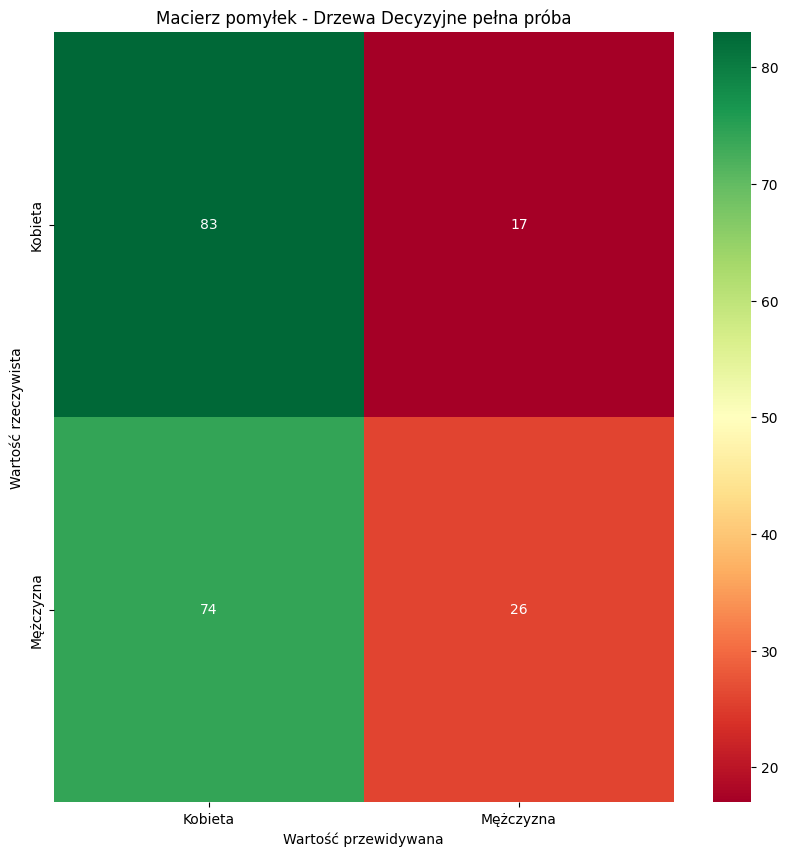

In [ ]:
tytul_wykresu='Drzewa Decyzyjne pełna próba'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# SMOTH

In [ ]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
model = DecisionTreeClassifier(random_state=42) #Dodane random_state=42, aby można jakoś porównać uzyskane wyniki (nie wpłynie na ich niezmienność z powodu losoweg odoboru próbki)
model.fit(X_train_smote, y_train_smote)

predykcje = model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1=f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna=precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna=recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna=f1_score(y_test, predykcje, pos_label='Mężczyzna')


print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')

Dokładność modelu: 0.575
F1: 0.5702621400945423
Macierz pomyłek: 
[[68 32]
 [53 47]]
Precyzja dla kobiet: 0.5619834710743802
Czułość dla kobiet: 0.68
F1 dla kobiet: 0.6153846153846154
Precyzja dla mężczyzn: 0.5949367088607594
Czułość dla mężczyzn: 0.47
F1 dla mężczyzn: 0.5251396648044693


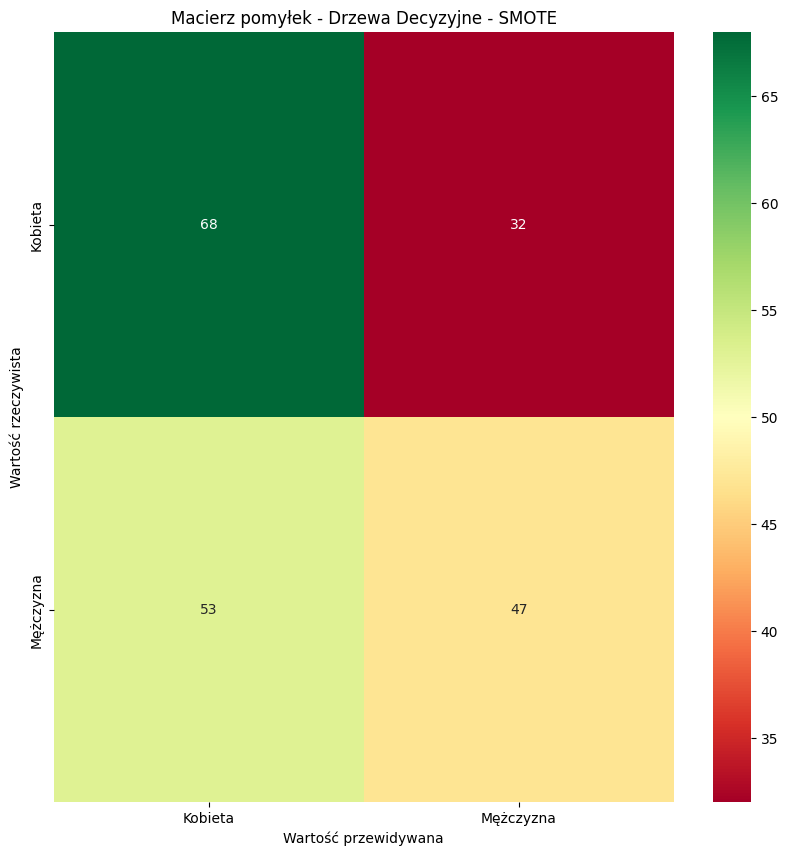

In [ ]:
tytul_wykresu='Drzewa Decyzyjne - SMOTE'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

## Zmniejszenie klasy kobiet

In [ ]:
df_2500=df.copy()
df_kobiety_2500 = df_2500[df_2500['Płeć'] == 'Kobieta'].sample(2500,replace=False)
df_mezczyzni_2500 = df_2500[df_2500['Płeć'] == 'Mężczyzna'].sample(2500,replace=False)
df_2500 = pd.concat([df_kobiety_2500, df_mezczyzni_2500])
df_2500 = df_2500.sample(frac=1).reset_index(drop=True)
df_2500

,Płeć,Akcje/obligacje/udziały w zyskach firmy,Bilety na imprezy kulturalne i sportowe,Bony towarowe,Ciekawa i urozmaicona praca,Darmowy bufet firmowy,Dobra atmosfera w miejscu pracy,Docenianie działań przez przełożonych,Dodatkowe ubezpieczenie na życie,Dodatkowe ubezpieczenie zdrowotne,...,"Szkolenia, studia, kursy",Telefon służbowy,"Udział, bądź realizacja ambitnych zadań, celów i projektów",Wyjazdy i imprezy integracyjne,Wysokość płacy zasadniczej,Zagrożenie przeniesienia na gorsze stanowisko,Zagrożenie utratą pracy,Znikomy poziom stresu,Zniżki na produkty i usługi firmowe,Zwrot za dojazdy do miejsca pracy
0,Mężczyzna,9,2,5,7,4,9,9,6,6,...,8,7,6,6,9,5,5,8,7,8
1,Kobieta,3,6,7,9,7,10,10,8,8,...,8,6,6,7,9,6,5,5,8,8
2,Kobieta,1,10,10,10,10,10,10,10,10,...,10,10,10,10,10,7,8,10,10,10
3,Mężczyzna,5,3,1,10,8,10,10,5,8,...,8,9,10,6,8,3,2,6,1,7
4,Kobieta,7,4,4,9,5,7,8,5,7,...,2,2,9,2,10,9,7,3,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Mężczyzna,1,10,5,8,9,10,10,10,10,...,9,4,9,8,9,1,1,10,6,9
4996,Kobieta,6,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
4997,Mężczyzna,10,5,5,8,1,7,8,10,10,...,9,1,7,6,10,1,1,10,10,6
4998,Kobieta,10,5,8,9,10,10,10,10,10,...,10,10,10,9,8,9,2,5,10,10


In [ ]:
X_train_2500 = df_2500.drop('Płeć', axis=1)
y_train_2500= df_2500['Płeć']

In [ ]:
model = DecisionTreeClassifier(random_state=42) #Dodane random_state=42, aby można jakoś porównać uzyskane wyniki (nie wpłynie na ich niezmienność z powodu losoweg odoboru próbki)
model.fit(X_train_2500, y_train_2500)

predykcje = model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1=f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna=precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna=recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna=f1_score(y_test, predykcje, pos_label='Mężczyzna')


print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')

Dokładność modelu: 0.52
F1: 0.5198079231692677
Macierz pomyłek: 
[[54 46]
 [50 50]]
Precyzja dla kobiet: 0.5192307692307693
Czułość dla kobiet: 0.54
F1 dla kobiet: 0.5294117647058824
Precyzja dla mężczyzn: 0.5208333333333334
Czułość dla mężczyzn: 0.5
F1 dla mężczyzn: 0.5102040816326531


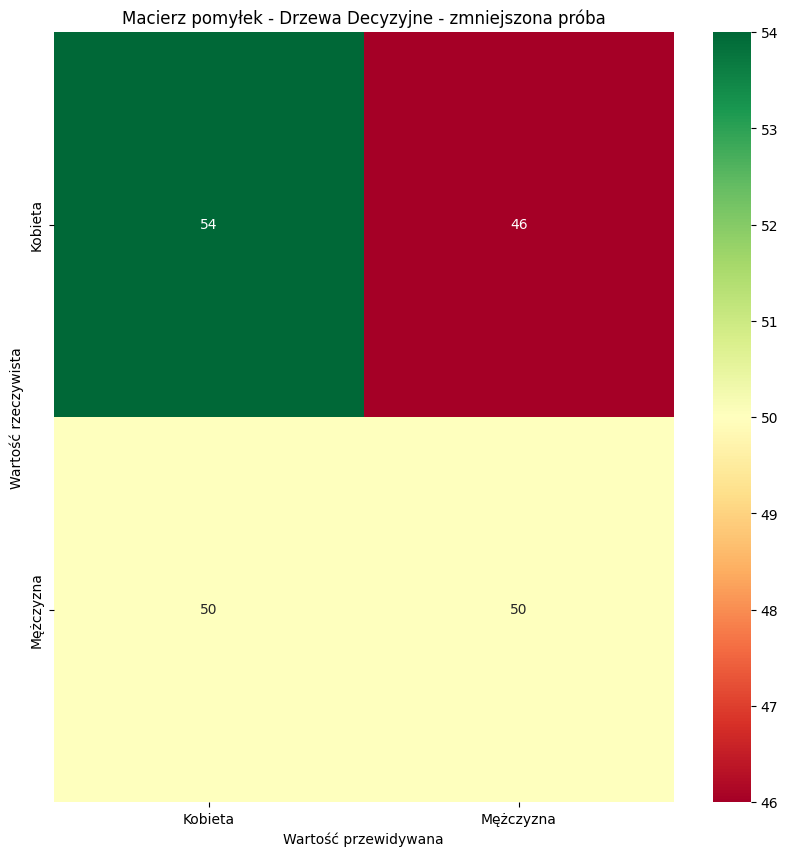

In [ ]:
tytul_wykresu='Drzewa Decyzyjne - zmniejszona próba'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# Bootstrap

In [ ]:
bootstrap_proba=100_000
df_bootstrap=pd.DataFrame()
df_bootstrap_kobiety=df[df['Płeć'] == 'Kobieta'].sample(bootstrap_proba,replace=True)
df_bootstrap_mezczyzni=df[df['Płeć'] == 'Mężczyzna'].sample(bootstrap_proba,replace=True)
df_bootstrap=pd.concat([df_bootstrap_kobiety, df_bootstrap_mezczyzni])
df_bootstrap = df_bootstrap.sample(frac=1).reset_index(drop=True)

In [ ]:
X_train_bootstrap = df_bootstrap.drop('Płeć', axis=1)
y_train_bootstrap = df_bootstrap['Płeć']

In [ ]:
model = DecisionTreeClassifier(random_state=42) #Dodane random_state=42, aby można jakoś porównać uzyskane wyniki (nie wpłynie na ich niezmienność z powodu losoweg odoboru próbki)
model.fit(X_train_bootstrap, y_train_bootstrap)

predykcje = model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1=f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna=precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna=recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna=f1_score(y_test, predykcje, pos_label='Mężczyzna')


print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')

Dokładność modelu: 0.565
F1: 0.510010982512461
Macierz pomyłek: 
[[90 10]
 [77 23]]
Precyzja dla kobiet: 0.5389221556886228
Czułość dla kobiet: 0.9
F1 dla kobiet: 0.6741573033707866
Precyzja dla mężczyzn: 0.696969696969697
Czułość dla mężczyzn: 0.23
F1 dla mężczyzn: 0.3458646616541353


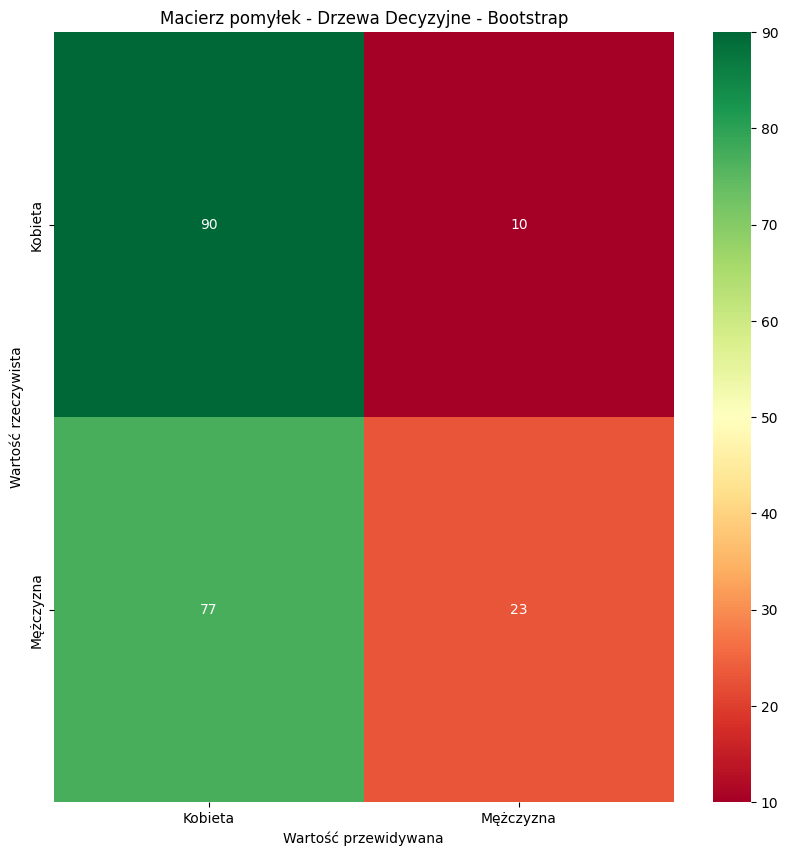

In [ ]:
tytul_wykresu='Drzewa Decyzyjne - Bootstrap'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

In [ ]:
df_bootstrap.value_counts('Płeć')

Płeć
Kobieta      100000
Mężczyzna    100000
dtype: int64

# Szukanie hiperparametrów

In [ ]:
model = DecisionTreeClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')


hiperparametry = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2'] + list(range(1, 45 + 1))
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=1000, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)


random_search.fit(X_train_2500, y_train_2500)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1 = f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna = precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna = recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna = f1_score(y_test, predykcje, pos_label='Mężczyzna')

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')


Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 39, 'min_samples_leaf': 17, 'min_samples_split': 16, 'splitter': 'best'}
Dokładność modelu: 0.545
F1: 0.544897601960441
Macierz pomyłek: 
[[53 47]
 [44 56]]
Precyzja dla kobiet: 0.5463917525773195
Czułość dla kobiet: 0.53
F1 dla kobiet: 0.5380710659898477
Precyzja dla mężczyzn: 0.5436893203883495
Czułość dla mężczyzn: 0.56
F1 dla mężczyzn: 0.5517241379310345


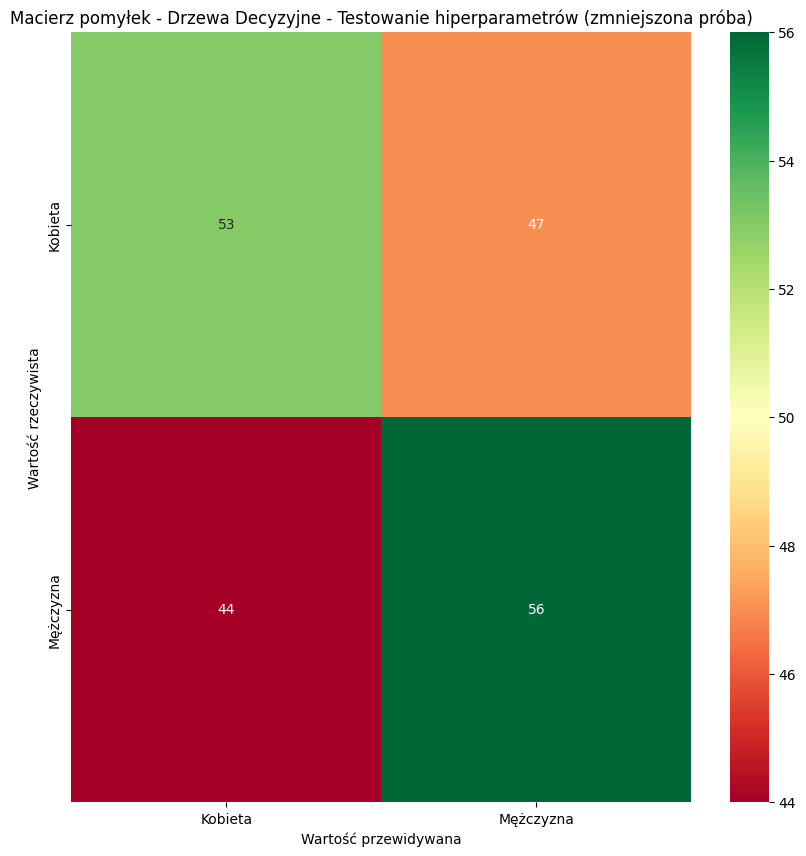

In [ ]:
tytul_wykresu='Drzewa Decyzyjne - Testowanie hiperparametrów (zmniejszona próba)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# Random Forest

musiałem zmniejszyć liczbe literacji oraz poziom kroswalidacji z powodu złożoności obliczeniowej.

In [ ]:
model = RandomForestClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')

hiperparametry = {
    'n_estimators': randint(10, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2'] + list(range(1, 45 + 1))
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=1000, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)

random_search.fit(X_train_2500, y_train_2500)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1 = f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna = precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna = recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna = f1_score(y_test, predykcje, pos_label='Mężczyzna')

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')



Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 13, 'max_features': 31, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 79}
Dokładność modelu: 0.615
F1: 0.6149133555049886
Macierz pomyłek: 
[[60 40]
 [37 63]]
Precyzja dla kobiet: 0.6185567010309279
Czułość dla kobiet: 0.6
F1 dla kobiet: 0.6091370558375634
Precyzja dla mężczyzn: 0.6116504854368932
Czułość dla mężczyzn: 0.63
F1 dla mężczyzn: 0.6206896551724137


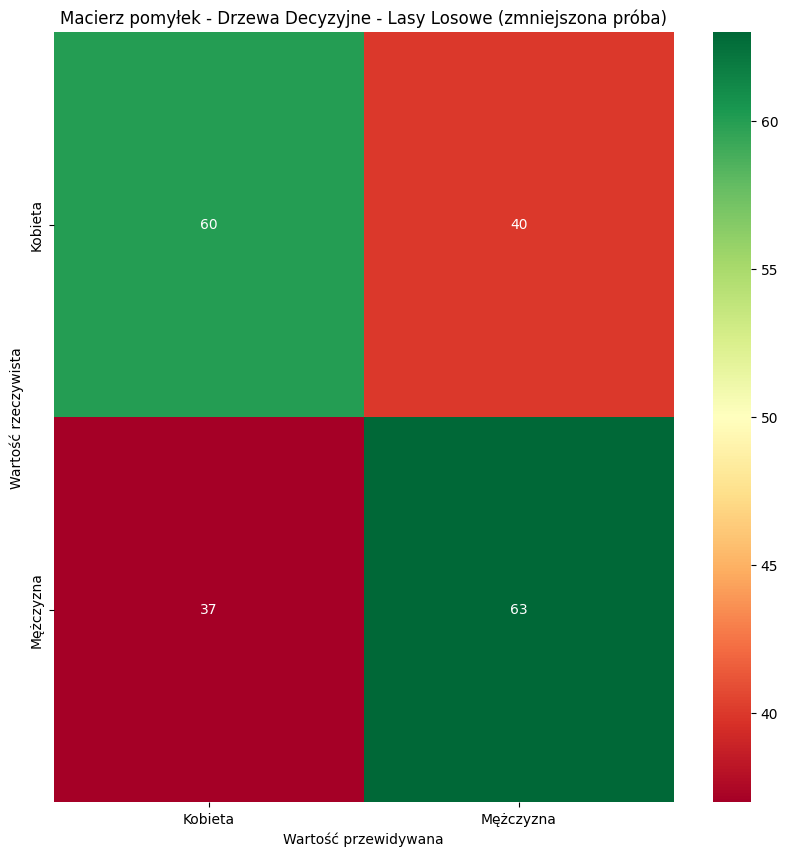

In [ ]:
tytul_wykresu='Drzewa Decyzyjne - Lasy Losowe (zmniejszona próba)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# XGBoost

In [ ]:
model = XGBClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')

#Trzeba tu zakodować klasy
y_train_2500_le=y_train_2500.map({'Kobieta': 0, 'Mężczyzna': 1})
y_test_le=y_test.map({'Kobieta': 0, 'Mężczyzna': 1})


hiperparametry = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 1.0),
    'colsample_bytree': uniform(0.5, 1.0),
    'gamma': uniform(0, 1),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': [1, 2, 5, 10],
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'max_delta_step': randint(1, 10),
    'min_split_loss': [0, 0.1, 0.2, 0.5, 1],
    'colsample_bylevel': uniform(0.5, 1.0),
    'colsample_bynode': uniform(0.5, 1.0),
    'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
    'booster': ['gbtree', 'gblinear', 'dart'],
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=1000, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)

random_search.fit(X_train_2500, y_train_2500_le)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test_le, predykcje)
c_m = confusion_matrix(y_test_le, predykcje)
f1 = f1_score(y_test_le, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test_le, predykcje, pos_label=0)
czulosc_kobieta = recall_score(y_test_le, predykcje, pos_label=0)
f1_kobieta = f1_score(y_test_le, predykcje, pos_label=0)

precyzja_mezczyzna = precision_score(y_test_le, predykcje, pos_label=1)
czulosc_mezczyzna = recall_score(y_test_le, predykcje, pos_label=1)
f1_mezczyzna = f1_score(y_test_le, predykcje, pos_label=1)

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3135 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 729, in inner_f

Najlepsze parametry: {'booster': 'gbtree', 'colsample_bylevel': 0.9894491986855394, 'colsample_bynode': 0.9886861951261473, 'colsample_bytree': 0.5775177097929858, 'gamma': 0.19077415201671966, 'learning_rate': 0.10629180783265019, 'max_delta_step': 1, 'max_depth': 6, 'min_child_weight': 9, 'min_split_loss': 0.5, 'n_estimators': 78, 'reg_alpha': 0.4090077367362732, 'reg_lambda': 0.5239742026857139, 'scale_pos_weight': 1, 'subsample': 0.9492371307759158, 'tree_method': 'exact'}
Dokładność modelu: 0.615
F1: 0.6142187930559384
Macierz pomyłek: 
[[57 43]
 [34 66]]
Precyzja dla kobiet: 0.6263736263736264
Czułość dla kobiet: 0.57
F1 dla kobiet: 0.5968586387434556
Precyzja dla mężczyzn: 0.6055045871559633
Czułość dla mężczyzn: 0.66
F1 dla mężczyzn: 0.6315789473684211


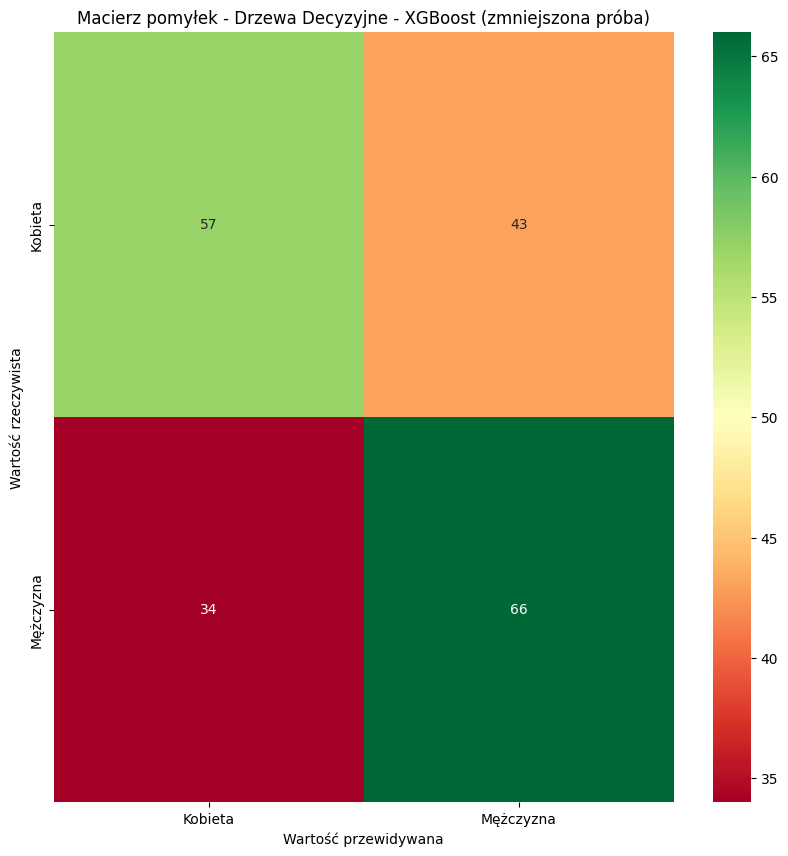

In [ ]:
tytul_wykresu='Drzewa Decyzyjne - XGBoost (zmniejszona próba)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# SMOTE


## Testowanie hiperparametrów

In [ ]:
model = DecisionTreeClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')


hiperparametry = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2'] + list(range(1, 45 + 1))
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=1000, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)


random_search.fit(X_train_smote, y_train_smote)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1 = f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna = precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna = recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna = f1_score(y_test, predykcje, pos_label='Mężczyzna')

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')


Najlepsze parametry: {'criterion': 'gini', 'max_depth': 17, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 3, 'splitter': 'best'}
Dokładność modelu: 0.565
F1: 0.5556577032099901
Macierz pomyłek: 
[[71 29]
 [58 42]]
Precyzja dla kobiet: 0.5503875968992248
Czułość dla kobiet: 0.71
F1 dla kobiet: 0.6200873362445415
Precyzja dla mężczyzn: 0.5915492957746479
Czułość dla mężczyzn: 0.42
F1 dla mężczyzn: 0.49122807017543857


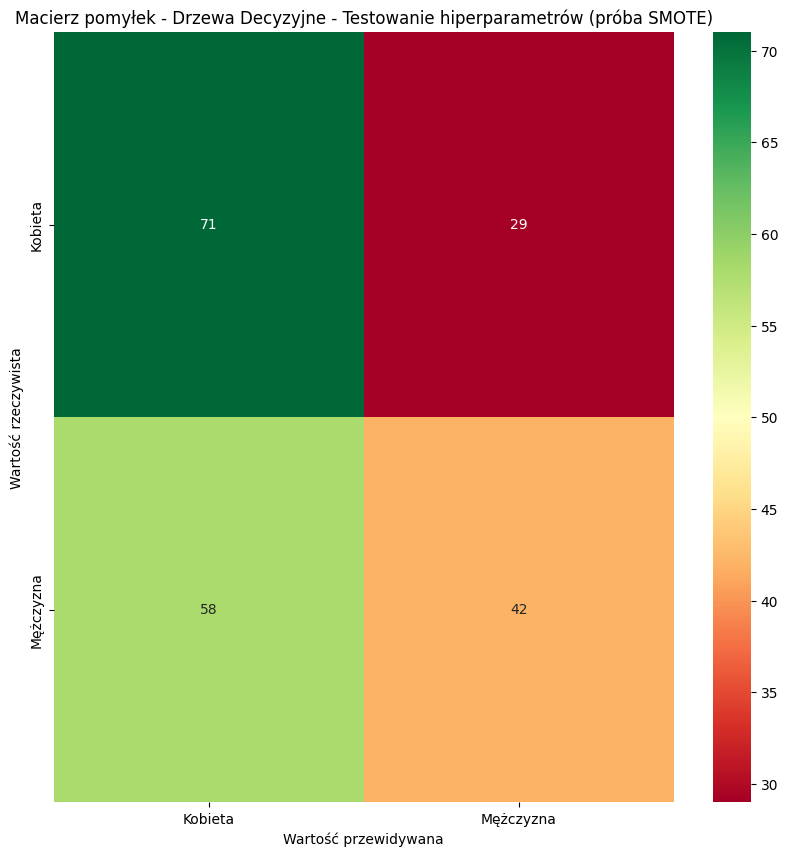

In [ ]:
tytul_wykresu='Drzewa Decyzyjne - Testowanie hiperparametrów (próba SMOTE)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

## Lasy losowe - SMOT

In [ ]:
model = RandomForestClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')

hiperparametry = {
    'n_estimators': randint(10, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2'] + list(range(1, 45 + 1))
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=1000, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)

random_search.fit(X_train_smote, y_train_smote)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test, predykcje)
c_m = confusion_matrix(y_test, predykcje)
f1 = f1_score(y_test, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test, predykcje, pos_label='Kobieta')
czulosc_kobieta = recall_score(y_test, predykcje, pos_label='Kobieta')
f1_kobieta = f1_score(y_test, predykcje, pos_label='Kobieta')

precyzja_mezczyzna = precision_score(y_test, predykcje, pos_label='Mężczyzna')
czulosc_mezczyzna = recall_score(y_test, predykcje, pos_label='Mężczyzna')
f1_mezczyzna = f1_score(y_test, predykcje, pos_label='Mężczyzna')

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')



tytul_wykresu='Drzewa Decyzyjne - Lasy Losowe (próba SMOTE)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

# XGB - SMOTE

In [ ]:
model = XGBClassifier(random_state=42)
f1_make_scorer = make_scorer(f1_score, average='macro')

#Trzeba tu zakodować klasy
y_train_smote_le=y_train_smote.map({'Kobieta': 0, 'Mężczyzna': 1})
y_test_le=y_test.map({'Kobieta': 0, 'Mężczyzna': 1})

(X_train_smote, y_train_smote)
hiperparametry = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 1.0),
    'colsample_bytree': uniform(0.5, 1.0),
    'gamma': uniform(0, 1),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': [1, 2, 5, 10],
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'max_delta_step': randint(1, 10),
    'min_split_loss': [0, 0.1, 0.2, 0.5, 1],
    'colsample_bylevel': uniform(0.5, 1.0),
    'colsample_bynode': uniform(0.5, 1.0),
    'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
    'booster': ['gbtree', 'gblinear', 'dart'],
}

random_search = RandomizedSearchCV(model, param_distributions=hiperparametry, n_iter=1000, cv=5, random_state=42, n_jobs=-1, scoring=f1_make_scorer)

random_search.fit(X_train_smote, y_train_smote_le)
najlepsze_parametry = random_search.best_params_
najlepszy_model = random_search.best_estimator_
predykcje = najlepszy_model.predict(X_test)

dokladnosc = accuracy_score(y_test_le, predykcje)
c_m = confusion_matrix(y_test_le, predykcje)
f1 = f1_score(y_test_le, predykcje, average='macro')

precyzja_kobieta = precision_score(y_test_le, predykcje, pos_label=0)
czulosc_kobieta = recall_score(y_test_le, predykcje, pos_label=0)
f1_kobieta = f1_score(y_test_le, predykcje, pos_label=0)

precyzja_mezczyzna = precision_score(y_test_le, predykcje, pos_label=1)
czulosc_mezczyzna = recall_score(y_test_le, predykcje, pos_label=1)
f1_mezczyzna = f1_score(y_test_le, predykcje, pos_label=1)

print(f'Najlepsze parametry: {najlepsze_parametry}')
print(f'Dokładność modelu: {dokladnosc}')
print(f'F1: {f1}')

print(f'Macierz pomyłek: \n{c_m}')
print(f'Precyzja dla kobiet: {precyzja_kobieta}')
print(f'Czułość dla kobiet: {czulosc_kobieta}')
print(f'F1 dla kobiet: {f1_kobieta}')
print(f'Precyzja dla mężczyzn: {precyzja_mezczyzna}')
print(f'Czułość dla mężczyzn: {czulosc_mezczyzna}')
print(f'F1 dla mężczyzn: {f1_mezczyzna}')

In [ ]:
tytul_wykresu='Drzewa Decyzyjne - XGBoost (próba SMOTE)'
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt='d', xticklabels=['Kobieta', 'Mężczyzna'], yticklabels=['Kobieta', 'Mężczyzna'], cmap='RdYlGn')
plt.title(f'Macierz pomyłek - {tytul_wykresu}')
plt.ylabel('Wartość rzeczywista')
plt.xlabel('Wartość przewidywana')
plt.savefig(tytul_wykresu.replace(" ", "_") + ".png")

In [ ]:
!cp * "/content/drive/MyDrive/dane/"